 ### Состав команды: 
##### Андрианова Екатерина
##### Гламаздин Василий
##### Люков Дмитрий
##### Пиксаев Алексей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyod.models.ocsvm import OCSVM
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from sklearn.model_selection import cross_val_score
from datetime import timedelta


import warnings
warnings.filterwarnings('ignore')

### Источники данных

1. IPC - Квартальные индексы потребительских цен на товары и услуги:
https://rosstat.gov.ru/price
2. KeyRate - Ключевая ставка ЦБ: https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.09.2017&UniDbQuery.To=31.03.2021
3. M2 - Денежная масса M2: http://www.cbr.ru/search/?Text=%D0%B4%D0%B5%D0%BD%D0%B5%D0%B6%D0%BD%D0%B0%D1%8F+%D0%BC%D0%B0%D1%81%D1%81%D0%B0
4. MB - Денежная база в широком определении: https://www.cbr.ru/statistics/macro_itm/dkfs/
5. USD_RUB - Курс доллара к рублю: https://www.finam.ru/profile/mosbirzha-valyutnyj-rynok/usdrubtod-usd-rub/export/?market=45&em=182456&token=&code=USD000000TOD&apply=0&df=1&mf=0&yf=2016&from=01.01.2016&dt=1&mt=0&yt=2022&to=01.01.2022&p=8&f=USD000000TOD_160101_220101&e=.csv&cn=USD000000TOD&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
6. EUR_RUB - Курс евро к рублю: https://www.finam.ru/profile/mosbirzha-valyutnyj-rynok/usdrubtod-usd-rub/export/?market=45&em=182456&token=&code=USD000000TOD&apply=0&df=1&mf=0&yf=2016&from=01.01.2016&dt=1&mt=0&yt=2022&to=01.01.2022&p=8&f=USD000000TOD_160101_220101&e=.csv&cn=USD000000TOD&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
7. Динамика ставки RUONIA: https://www.cbr.ru/hd_base/ruonia/dynamics/?UniDbQuery.Posted=True&UniDbQuery.From=09.01.2017&UniDbQuery.To=31.03.2021
8. NASDAQ : https://www.finam.ru/profile/mirovye-indeksy/nasdaq/export/?market=6&em=82075&token=&code=IXIC&apply=0&df=9&mf=0&yf=2017&from=09.01.2017&dt=31&mt=2&yt=2021&to=31.03.2021&p=8&f=IXIC_170109_210331&e=.csv&cn=IXIC&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
9. S&P500: https://www.finam.ru/profile/mirovye-indeksy/sandp-500/export/?market=6&em=90&token=03AGdBq27I3OZSpZ6hw3mYO0oh_jLatBVw8EgM_335m2of-5w5ygcZh3sckWyd9xCjTsLRZp5bIJ7DTHEeN1-GKwoWCZtPZoI7xWk7zvI_VxVZ-Pz3D1F0c6WkIwjGyi6MtP-XvXWox33aQIi63sKmyaStLG1u4HzFs_gaGMvm1p5oxs9MxpGByjpmt3xh4reRfWysCLtkc8FA2w0sieUUPOmDOjpGc9fOBX6thC5EPC9nSR9PMOwVXjl68f4HMmFzR7K202-0L6JcK-MsIXH65GTN0x7KI2MDxxHtNPXV5uzzFzweoldr7473xsPMmW4NAZebErsjpV4EpJoNxNdEa1ElRyHiiCOLxtAsO3jbiU8n2vAvdXd3UBHCI3jqIX4ULwak789zA05mNFXTURlJ6wVIQ8CjQDObWuO2mhx25weAV_YEoYaeFh7VmOlnsnonRLigGAo_3Eu_&code=INX&apply=0&df=9&mf=0&yf=2017&from=09.01.2017&dt=31&mt=2&yt=2021&to=31.03.2021&p=8&f=INX_170109_210331&e=.csv&cn=INX&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
10. Индекс Мосбиржи: https://www.finam.ru/profile/mirovye-indeksy/micex/export/?market=6&em=13851&token=03AGdBq24y4DqVj04pyiwtZAZkhQaBx6j2mv9nc1SdgUWjubX75npFVlG2yClbYPwfOZ7r3KuAC8Z3QnIfdoB8rP4c2fsVp-jCxgd7wgWLY4b-o29q-RV1QV89_cRo0zWhVfO0UPza1fty1irsp1V77jfFcpFBjy5m8AOzC-lX2GC4jMIPWa8AobTWjiWlnfgFO43J-cV97juA4Hn1G-kRFQSnFB-2y0lekT1JXBv1qKGH9WXiEhHvju_zMuUFYfYImRHFGIiLRDYLCQNOIHDcJJIrMtaPQbZhX79whP4dfatQE0bjZL7nDTC3CCu8Iw2MRMAwzHLSU5TNCUd6yHB6GVtMHY_AtF3aLthQKVYEYHK_s79Md6pin67TVg1olXYo-6iymmIpPXN360HHADXYzoJNy9it9LaUXUs3ienRmFiEi0iWugeGpeNpxSJyrIcc_hvMRiN2cJRJ&code=IMOEX&apply=0&df=9&mf=0&yf=2017&from=09.01.2017&dt=31&mt=2&yt=2021&to=31.03.2021&p=8&f=IMOEX_170109_210331&e=.csv&cn=IMOEX&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1
11. BRENT: https://www.finam.ru/profile/tovary/brent/export/?market=24&em=19473&token=03AGdBq25KvMBGTtEWV-xi3yssXJy2rSY0n9lNMu4tvraOJrUlRQrJnkJr1DSHDFp16Rm5Lp9E1sPk3RPZ-PLJGAYnVs_pVBZdA0lDyAVV8es1JoHf8qcG8i44zY9maZTL_oQxUXIPD52CF5H043ahq-C-ntqaqD2D5GbkmsEQi_SwJYyB3uLxoENyKRH2DPLq6ZbxFvPHaeX1rvTekCYTLXR_qasSmXtkQJpF-doBWppL8qhyI7x06mtoA-hfwdmay7f1OAqxVjS5lnx7lqjZAuBKrKSGszioJp3x0zdt3Nyfsofmvfn5W7TUVVlcnTetL8hSl2rm9YWrcTT-nTUMfvCtAgqK7wgUB_Kg-OcxZKFnW9_0X2eliGtQRgzaQUQtPDCRBO25QIuga2hfSFMjZ4V6IfTlibyyr7C3jh7qnkD_urPAcR4_IR7xESaUAyKRtfX6CoSyaJQa&code=BZ&apply=0&df=9&mf=0&yf=2017&from=09.01.2017&dt=31&mt=2&yt=2021&to=31.03.2021&p=8&f=BZ_170109_210331&e=.csv&cn=BZ&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1

### Препроцессинг данных

In [ ]:
def get_data(target_path, features_path):
    target_df = pd.read_excel(target_path, parse_dates=['Date'], index_col='Date')
    target_df = target_df.resample('D').sum()
    target_df = target_df[target_df != 0].dropna().asfreq('D', method='ffill')
    features_df = pd.read_excel(features_path, parse_dates=['Date'], index_col='Date')
    return target_df, features_df

def make_timeseries_features(data, window_weekdays=3, window_days=7, lags=(1, 11)):

    # Лаги
    for i in range(lags[0], lags[1]):
        data['lag_{}'.format(i)] = data.Balance.shift(i)

    # rolling functions
    data['rolling_mean'] = data.rolling(window_days).mean().Balance.shift(1)
    data['rolling_median'] = data.rolling(window_days).median().Balance.shift(1)
    data['rolling_max'] = data.rolling(window_days).max().Balance.shift(1)
    data['rolling_min'] = data.rolling(window_days).min().Balance.shift(1)
    data['rolling_std'] = data.rolling(window_days).std().Balance.shift(1)

    # rolling functions grouped by day of week
    data['rolling_mean_weekday'] = data.groupby(data.index.weekday)['Balance'].transform(lambda x: x.rolling(window_weekdays).mean().shift(1))
    data['rolling_max_weekday'] = data.groupby(data.index.weekday)['Balance'].transform(lambda x: x.rolling(window_weekdays).max().shift(1))
    data['rolling_min_weekday'] = data.groupby(data.index.weekday)['Balance'].transform(lambda x: x.rolling(window_weekdays).min().shift(1))
    data['rolling_median_weekday'] = data.groupby(data.index.weekday)['Balance'].transform(lambda x: x.rolling(window_weekdays).median().shift(1))
    data['rolling_std_weekday'] = data.groupby(data.index.weekday)['Balance'].transform(lambda x: x.rolling(window_weekdays).std().shift(1))

    return data


def prepare_data(target_df, features_df):

    data = make_timeseries_features(pd.DataFrame(target_df.copy()))

    # Дамми-переменная на аномальность
    minmax = MinMaxScaler(feature_range=(0, 1))
    X = minmax.fit_transform(data.Balance.values.reshape(-1, 1))
    clf = OCSVM(contamination=0.1)
    clf.fit(X)
    data['is_anomaly'] = clf.predict(X)

    # Среднее по дням недели и дамми на выходные
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    data['weekday_average'] = list(map(code_mean(data, 'weekday', 'Balance').get, data.weekday))
    data.drop(['weekday'], axis=1, inplace=True)

    # Добавляем макроэкономические факторы
    data = data.join(features_df)
    data.dropna(inplace=True)
    return data


def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

### Кастомный лосс

1. Если денег потребовалось больше, чем мы думали (y_true > y_pred), мы вынуждены занять под (ключ + 1), в то время, как на деске крутится та же сумма под (ключ + 0.5). То есть, по сравнению с ситуацией, как если бы мы предсказали идеально, мы понесем убыток, эквивалентный 0.5%
2. Если денег потребовалось меньше, то есть мы зарезеривировали слишком много (y_pred > y_true), то мы кладем их под (ключ - 0.9), а могли бы вместо этого закинуть на деск под (ключ + 0.5) (если бы предсказывали идеально). Недополученная прибыль эквивалентна 1.4%.

In [ ]:
def assymetric_loss(y_true, y_pred):
    return np.mean(
        np.maximum(y_true - y_pred, 0) * (0.005 / 365) + \
        np.maximum(y_pred - y_true, 0) * (0.014 / 365)
    )

assymetric_scorer = make_scorer(assymetric_loss, greater_is_better=False)

# BASE_SCORE = 'neg_mean_absolute_error'
BASE_SCORE = assymetric_scorer

### Отбор признаков

In [ ]:
# Масштабирование
def scale_data(X):
    x_scaled = X.copy()
    for col in X.columns:
        if pd.api.types.is_float_dtype(X[col]) and len(np.unique(X[col])) > 2:
            x_scaled[col] = StandardScaler().fit_transform(X[[col]])
    return x_scaled

# Заглушка для оптимизации кроссвалидации
def cv_score(alpha, X, y, random_state):
    cv = TimeSeriesSplit(n_splits=3)
    model = Lasso(alpha=alpha, random_state=random_state)
    score = cross_val_score(model, X, y, scoring=BASE_SCORE, cv=cv)
    return -np.mean(score)

# Ищем оптимальный коэффициент регуляризации
def find_best_alpha(X, y, random_state):
    opt = minimize(cv_score, x0=np.array([0.1]), args=(X, y, random_state), method="TNC", bounds=[(0, 1)])
    return opt.x[0]

# Подбор признаков с помощью регрессии Лассо
def select_features_using_lasso(X, y):
    # print("Start select features by Lasso")
    result = np.full((len(X.columns),), False, dtype=bool)
    for random_state in range(1, 5):
        best_alpha = find_best_alpha(X, y, random_state)
        selector = Lasso(alpha=best_alpha, random_state=random_state)
        selector.fit(X, y)
        result = result | (selector.coef_ > 0)
    # print(f'Select {X.columns[result]}')
    return result

# Отбор фичей с помощью фильтрации
def select_features_using_filter(X, y, k):
    # print("Start select features by filter")
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(X, y)
    result = selector.get_support()
    # print(f'Select {X.columns[result]}')
    return result

# Отбор фичей с помощью линейной корреляции
def select_features_using_corr(X, y, threshold=0.2):
    # print("Start select features by correlation")
    correlations = X.apply(lambda x: x.corr(y))
    result = np.abs(correlations) > threshold
    # print(f'Select {X.columns[result]}')
    return result

# Отбор фичей с помощью нелинейного метода
def select_features_using_no_lin(X, y):
    # print("Start select features by no lin method")
    cv = TimeSeriesSplit(n_splits=3)
    result = np.full((len(X.columns),), False, dtype=bool)
    for random_state in range(1, 5):
        model = GradientBoostingRegressor(random_state=random_state)
        base_score = -np.mean(cross_val_score(model, X, y, scoring=BASE_SCORE, cv=cv))
        scores = []
        for feature in X.columns:
            score = -np.mean(cross_val_score(model, X.drop(feature, axis=1), y, scoring=BASE_SCORE, cv=cv))
            scores.append(score - base_score)
        result = result | (np.array(scores) > 0)
    # print(f'Select {X.columns[result]}')
    return result

def select_features(X, y, logs=False):
    x_scaled = scale_data(X)

    features_no_lin = select_features_using_no_lin(X, y)
    features_lasso = select_features_using_lasso(x_scaled, y)
    features_corr = select_features_using_corr(x_scaled, y)
    features_filter = select_features_using_filter(x_scaled, y, X.shape[1] // 3 * 2)
    
    if logs:
        print('Что не выбрали по отдельности', X.columns[~features_no_lin], X.columns[~features_lasso], X.columns[~features_corr], X.columns[~features_filter])
        print('Выкидываем точно', X.columns[~features_no_lin & ~features_lasso & ~features_corr & ~features_filter])

    selected = features_no_lin & (features_lasso | features_corr | features_filter)
    if logs:
        print(selected)
    return selected

### Подбор гиперпараметров для LGBM

In [ ]:
import optuna.logging as log
log.set_verbosity(log.ERROR)

def optimize_lgbm(X, y, n_trials=100):
    def objective(trial):
        params = {
            'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
            'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
            'min_split_gain': trial.suggest_discrete_uniform('min_split_gain', 0.1, 5, 0.01),
            'max_depth': trial.suggest_int('max_depth', 1, 9),
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
            'max_bin': trial.suggest_int('max_bin', 32, 255),
            'random_state': 42,
            'class_weight': 'balanced',
        }

        cv = TimeSeriesSplit(n_splits=3)
        model = LGBMRegressor(**params)
        scores = cross_val_score(model, X, y, cv=cv, scoring=BASE_SCORE, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=1)
    study = create_study(direction='maximize', study_name="LGBM Regressor", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_pars_mass = study.best_params
    print(f'Best score {study.best_value}')
    return best_pars_mass

### Подбор гиперпараметров для Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def optimize_rf(X, y, n_trials=100):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'n_jobs': -1,
            'random_state': 42,
        }

        cv = TimeSeriesSplit(n_splits=3)
        model = RandomForestRegressor(**params)
        scores = cross_val_score(model, X, y, cv=cv, scoring=BASE_SCORE, verbose=False)
        score = np.mean(scores)

        return score

    sampler = TPESampler(seed=1)
    study = create_study(direction='maximize', study_name="RF Regressor", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_pars_mass = study.best_params
    print(f'Best score {study.best_value}')
    return best_pars_mass

### Модуль для поиска разладки

In [ ]:
def one_pass(train_zone, prediction_zone, threshold=15, drift=3.0):
    """
    threshold : positive number, optional (default = 10)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 2.0)
        drift term that prevents any change in the absence of change
        
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.
    """

    current_std = train_zone.std(ddof=1)
    current_mean = train_zone.mean()

    drift *= current_std
    threshold *= current_std

    x = np.atleast_1d(prediction_zone).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    gp_prev = gp[0]
    gn_prev = gn[0]

    for i in range(1, x.size):
        gp[i] = gp_prev + x[i] - (current_mean + drift)
        gn[i] = gn_prev + x[i] - (current_mean - drift)

        gp_prev, gn_prev = gp[i], gn[i]

        if gp[i] < 0:
            gp_prev = 0
        if gn[i] > 0:
            gn_prev = 0

    is_fault = np.logical_or(gp > threshold, gn < -threshold)
    return is_fault


def detect_historical(time_series, backward_window_size=20, forward_window_size=10, threshold=15, drift=3.0):
    
    detection_series = pd.Series(index=time_series.index, data=0)

    for ini_index in range(len(time_series) - (backward_window_size + forward_window_size)):
        sep_index = ini_index + backward_window_size
        end_index = sep_index + forward_window_size
        faults_indexes = one_pass(time_series.iloc[ini_index:sep_index],
                                  time_series.iloc[sep_index:end_index],
                                  threshold, drift)
        detection_series.iloc[sep_index:end_index][faults_indexes] = 1
    return detection_series


def detect_and_visualize(time_series, backward_window_size=20, forward_window_size=10, threshold=15, drift=3.0):
    
    anomalies = pd.Series(np.where(detect_historical(time_series, backward_window_size, 
                                                     forward_window_size, 
                                                     threshold, drift) == 1, time_series, np.nan),
                          index=time_series.index)
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(15, 6))
        plt.title('Cusum Anomaly Detection', fontdict={'fontsize': 20})
        plt.plot(time_series, label='actual')
        plt.plot(anomalies, 'o', color='r', markersize=7, label='anomalies')
        plt.show()

        
def find_changepoint(s, found):
    counter = 1
    for i in range(s.size-1):
        if s[i]:
            if s[i+1] == s[i]:
                counter += 1
            elif counter > 6:
                if s.index[i+1] not in found:
                    return s.index[i+1] # end change
                else: counter = 1
            else: 
                counter = 1

    return 'No changepoint'

### Пайплайн

In [ ]:
# Подбор фичей и гиперпараметров для модели
def prepare_model(X, y, start_date, end_date):
    X_train, y_train = X.loc[start_date:end_date], y[start_date:end_date]
    
    selected_features = select_features(X_train, y_train)
    selected_features = selected_features[selected_features == True].index
    
    # best_params = optimize_lgbm(X_train[selected_features], y_train, 100)
    best_params = optimize_rf(X_train[selected_features], y_train, 50)
    model = RandomForestRegressor(**best_params)
    model.fit(X_train[selected_features], y_train)
    
    return model, selected_features


In [ ]:
# Запуск пайплайна на исторических данных
def prediction_pipeline(timeseries_path='Project 2_2022.xlsx', features_path='features_v3.xlsx', first_date=None):
    target_df, features_df = get_data(timeseries_path, features_path)
    data = prepare_data(target_df['Balance'], features_df)
    X, y = data.drop('Balance', axis=1), data.Balance

    train_size = 180
    start_date = X.index[0]
    if first_date:
        end_date = first_date
    else: end_date = X.index[train_size]
    test_date = end_date   
    model, selected_features = prepare_model(X, y, start_date, end_date)
    
    period_train = 90
    period_counter = 0
    anomaly_counter = 0
    found = []
    predictions = pd.Series(index=X.index)
    
    for day in tqdm(X.index[X.index >= test_date]):
        period_counter +=1
        prediction = model.predict(X.loc[day][selected_features].values.reshape(1,-1))
        predictions.loc[day] = prediction

        changepoint = find_changepoint(detect_historical(predictions), found)
        if changepoint != 'No changepoint':
            found.append(changepoint)
            if anomaly_counter >= train_size:
                end_date = day + timedelta(days=1)
                start_date = changepoint
                model, selected_features = prepare_model(X, y, start_date, end_date)
                anomaly_counter, period_counter = 0, 0
                continue
            else:
                print(f"A breakdown was found (It's at {changepoint})") 
                print('History is not enough for retraining. Transition to manual control.')
                break
        else: anomaly_counter += 1
        
        if period_counter == period_train:
            # Дообучаем модель
            end_date = day + timedelta(days=1)
            model, selected_features = prepare_model(X, y, start_date, end_date)
            period_counter = 0
            
    return predictions
        
    


In [ ]:
def show_results(predictions, timeseries_path='Project 2_2022.xlsx', features_path='features_v3.xlsx'):
    
    target_df, features_df = get_data(timeseries_path, features_path)
    data = prepare_data(target_df['Balance'], features_df) #
    y_true = data.Balance
    
    print(f'Rate of bad predictions: {np.sum(np.abs(y_true-predictions) >= 0.42)/predictions.size:0.3f}')
    print(f'Business metric value: {assymetric_loss(y_true, predictions)}')
    
    plt.figure(figsize=(20,10))
    plt.title('Prediction results:')
    plt.plot(y_true.index, y_true, label='True values')
    plt.plot(predictions.index, predictions, label='Predicted values')
    plt.grid()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.title('Absolute errors:')
    plt.plot(predictions.index, [0.42]*predictions.size, label='Allowable absolute error')
    plt.plot(predictions.index, np.abs(y_true-predictions), label='Observable absolute error')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
%%time
predictions = prediction_pipeline(timeseries_path='Project 2_2022.xlsx', features_path='features_v3.xlsx')


Best score -5.477914646134136e-06



Best score -4.89383679447096e-06



Best score -4.856177428784762e-06



Best score -4.924539988161402e-06



Best score -5.486440548000421e-06



Best score -5.067234795361857e-06



Best score -4.761267869155197e-06



Best score -5.006525851297407e-06



Best score -5.419755612075551e-06



Best score -5.312961189934089e-06



Best score -5.79240079183337e-06



Best score -4.937259238707598e-06



Best score -5.1275725276081584e-06



Best score -4.81104496138584e-06



Best score -5.75588073192398e-06

Wall time: 1h 11min 12s


Rate of bad predictions: 0.085
Business metric value: 5.40737179331653e-06


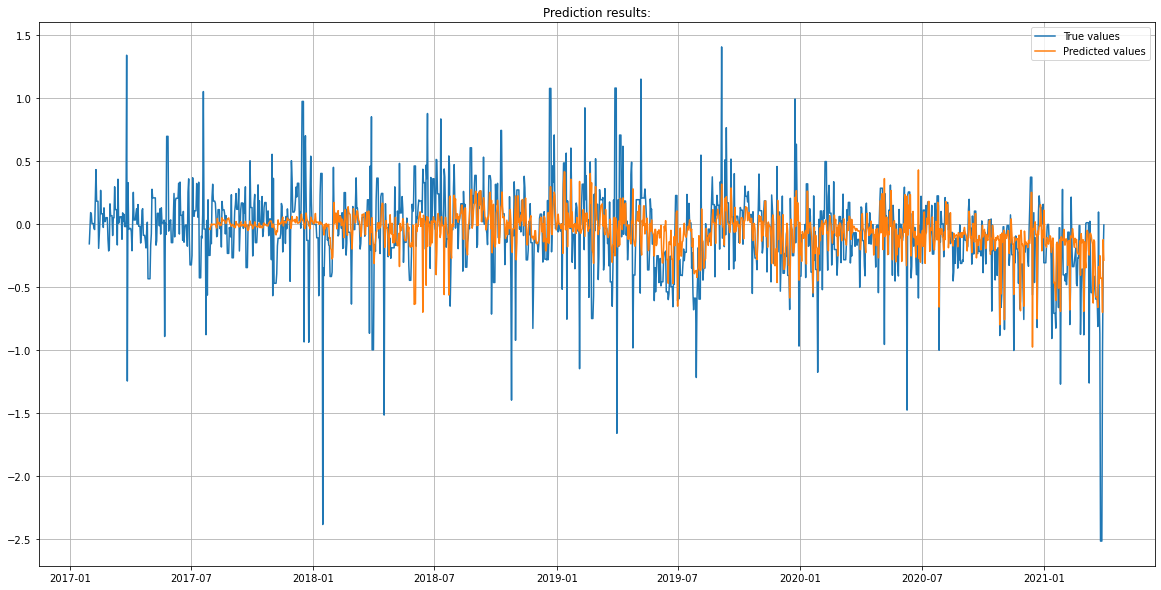

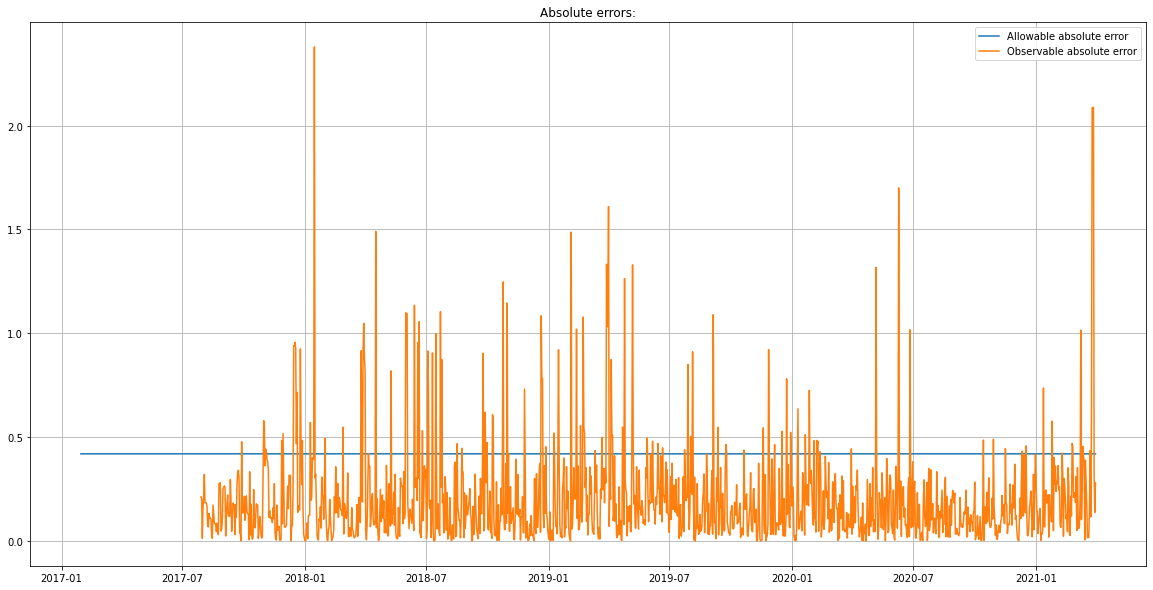

In [ ]:
show_results(predictions)